In [ ]:
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(palette="Set2")

# Decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

# Train-test split
from sklearn.model_selection import train_test_split

# Models
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.api import Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Model evaluation
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_absolute_error as mae

# setting logging to print only error messages from Sklearnex
import logging
logging.basicConfig()
logging.getLogger("SKLEARNEX").setLevel(logging.ERROR)

import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving AirPassengers.csv to AirPassengers (1).csv


In [ ]:
df = pd.read_csv('AirPassengers.csv')

In [ ]:
df.head()

,Month,Passengers (k)
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


# **EDA and Data Preprocessing**

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Month           144 non-null    object
 1   Passengers (k)  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [ ]:
df['Month'] = pd.to_datetime(df['Month'])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Month           144 non-null    datetime64[ns]
 1   Passengers (k)  144 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.4 KB


In [ ]:
df.sort_values(by=['Month'], inplace=True, ascending=True)

In [ ]:
df.set_index("Month", inplace=True)

**Missing Check**

In [ ]:
min(df.index), max(df.index)

(Timestamp('1949-01-01 00:00:00'), Timestamp('1960-12-01 00:00:00'))

In [ ]:
all_datetimes = pd.date_range(min(df.index), max(df.index), freq="MS")
all_datetimes

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', length=144, freq='MS')

In [ ]:
all_datetimes.shape

(144,)

In [ ]:
all_datetimes_df = pd.DataFrame(index=all_datetimes)
all_datetimes_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Freq: MS
Empty DataFrame


In [ ]:
df = pd.merge(all_datetimes_df, df, how="left", left_index=True, right_index=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Freq: MS
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   Passengers (k)  144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB


<Axes: >

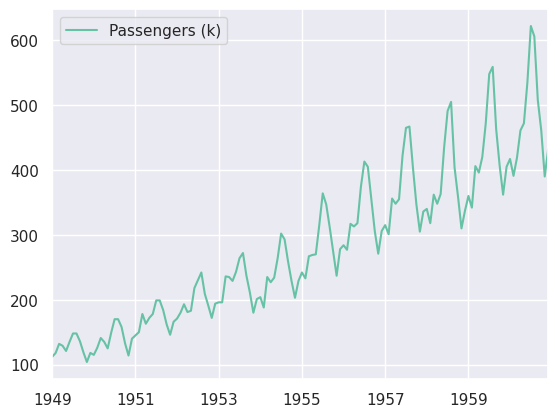

In [ ]:
df.plot()

There is no missing entries in the dataset.

**Decomposition**

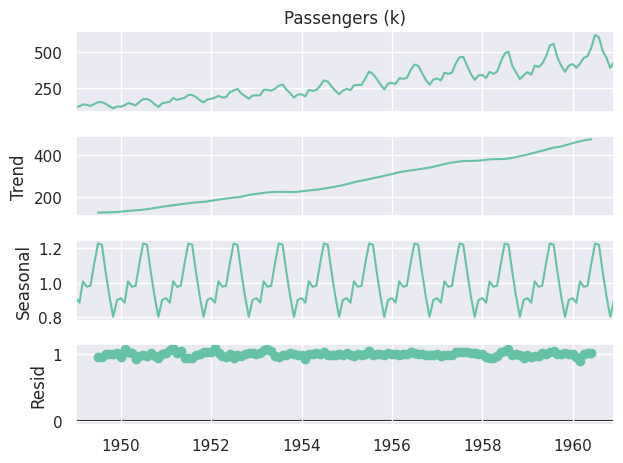

In [ ]:
decomposition_plot = seasonal_decompose(df['Passengers (k)'], model='multiplicative')
decomposition_plot.plot()
plt.show()

The dataset displays a clear upward trend and a seasonality.

# **Forecasting**

## **Smoothing**

In [ ]:
train, test = train_test_split(df, test_size=0.2,
                               random_state=2025, shuffle=False)

In [ ]:
train.shape, test.shape

((115, 1), (29, 1))

**Moving Average**

In [ ]:
df.head()

,Passengers (k)
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [ ]:
train["4MA"] = train["Passengers (k)"].rolling(window=4).mean()
train["12MA"] = train["Passengers (k)"].rolling(window=12).mean()

In [ ]:
train.head(15)

,Passengers (k),4MA,12MA
1949-01-01,112,NaN,NaN
1949-02-01,118,NaN,NaN
1949-03-01,132,NaN,NaN
1949-04-01,129,122.75,NaN
1949-05-01,121,125.00,NaN
1949-06-01,135,129.25,NaN
1949-07-01,148,133.25,NaN
1949-08-01,148,138.00,NaN
1949-09-01,136,141.75,NaN
1949-10-01,119,137.75,NaN


<Axes: >

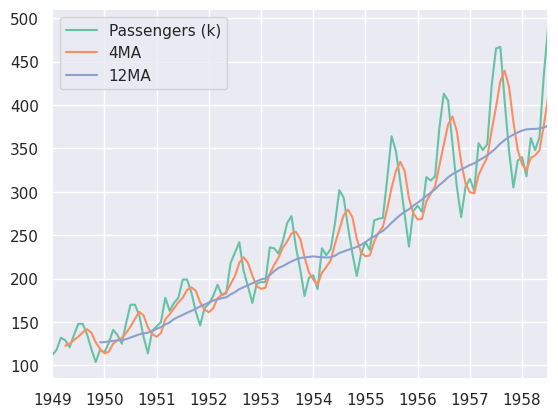

In [ ]:
train[["Passengers (k)", "4MA", "12MA"]].plot()

In [ ]:
# Drop NaN values caused by rolling window
valid_4MA = train.dropna(subset=['4MA'])
valid_12MA = train.dropna(subset=['12MA'])

# Calculate MAE
mae_4MA = mae(valid_4MA['Passengers (k)'], valid_4MA['4MA'])
mae_12MA = mae(valid_12MA['Passengers (k)'], valid_12MA['12MA'])

# Calculate MAPE
mape_4MA = mape(valid_4MA['Passengers (k)'], valid_4MA['4MA'])
mape_12MA = mape(valid_12MA['Passengers (k)'], valid_12MA['12MA'])

print(f"4-MA -> MAE: {mae_4MA:.2f}, MAPE: {mape_4MA*100:.2f}%")
print(f"12-MA -> MAE: {mae_12MA:.2f}, MAPE: {mape_12MA*100:.2f}%")

# Choose the better one
if mae_4MA < mae_12MA:
    print("4-MA performs better.")
else:
    print("12-MA performs better.")

4-MA -> MAE: 21.50, MAPE: 8.69%
12-MA -> MAE: 28.34, MAPE: 10.49%
4-MA performs better.


Because the 4-period Moving Average performs better compared to the 12-period moving average, thus, we use 4MA to forecast the test set.

In [ ]:
test["4MA"] = test["Passengers (k)"].rolling(window=4).mean()

# Drop NaN values caused by rolling window
valid_4MA = test.dropna(subset=['4MA'])

# Calculate MAE
mae_4MA = mae(valid_4MA['Passengers (k)'], valid_4MA['4MA'])

# Calculate MAPE
mape_4MA = mape(valid_4MA['Passengers (k)'], valid_4MA['4MA'])

print(f"MAE: {mae_4MA:.2f}, MAPE: {mape_4MA*100:.2f}%")

MAE: 46.99, MAPE: 10.58%


<Axes: >

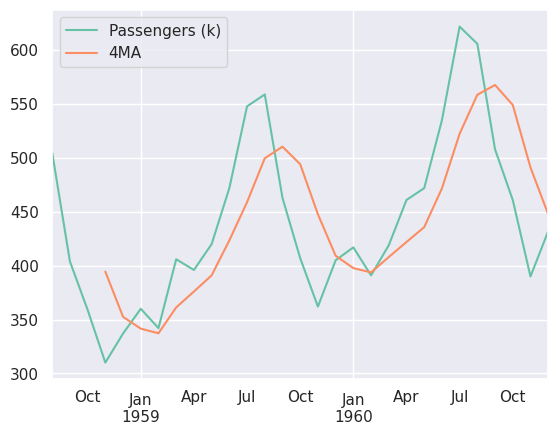

In [ ]:
test[["Passengers (k)", "4MA"]].plot()

**Simple Exponential Smoothing**

In [ ]:
# Create a Simple Exponential Smoothing model using the training data
model_ses = SimpleExpSmoothing(train['Passengers (k)']).fit()

# Fit the model
predictions_ses = model_ses.forecast(len(test))

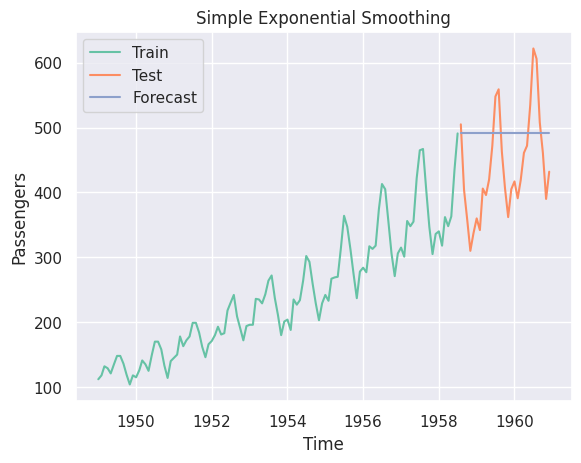

In [ ]:
# Plot the train, test, and forecast data
plt.plot(train['Passengers (k)'], label='Train')
plt.plot(test['Passengers (k)'], label='Test')
plt.plot(predictions_ses, label="Forecast")

# Add title and legend to the plot
plt.title("Simple Exponential Smoothing")
plt.xlabel("Time")
plt.ylabel("Passengers")
plt.legend()
plt.show()

In [ ]:
mae_ses = mae(test["Passengers (k)"], predictions_ses)
mape_ses = mape(test["Passengers (k)"], predictions_ses)

print(f"The MAE is {mae_ses:.2f}")
print(f"The MAPE is {100 * mape_ses:.2f} %")

The MAE is 81.45
The MAPE is 20.20 %


**Double Exponential Smoothing**

In [ ]:
from statsmodels.tsa.api import Holt

model_double = Holt(train["Passengers (k)"])
model_double_fit = model_double.fit()

In [ ]:
# Forecast same length as test set
predictions_des = model_double_fit.forecast(len(test))

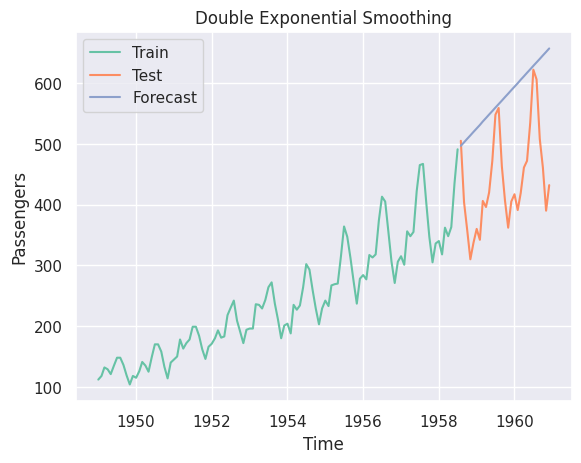

In [ ]:
# Plot the train, test, and forecast data
plt.plot(train['Passengers (k)'], label='Train')
plt.plot(test['Passengers (k)'], label='Test')
plt.plot(predictions_des, label="Forecast")

# Add title and legend to the plot
plt.title("Double Exponential Smoothing")
plt.xlabel("Time")
plt.ylabel("Passengers")
plt.legend()
plt.show()

In [ ]:
mae_des = mae(test["Passengers (k)"], predictions_des)
mape_des = mape(test["Passengers (k)"], predictions_des)

print(f"The MAE is {mae_des:.2f}")
print(f"The MAPE is {100 * mape_des:.2f} %")

The MAE is 137.11
The MAPE is 34.17 %


**Holt-Winters (Triple Exponential Smoothing)**

This technique is used when the data shows both trend and seasonal patterns.




In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Fit model with trend and seasonality
model_hw = ExponentialSmoothing(
    train['Passengers (k)'],
    trend='mul',
    seasonal='mul',
    seasonal_periods=12  # or 4 if quarterly, adjust as needed
).fit()

# Forecast same length as test set
predictions_hw = model_hw.forecast(len(test))

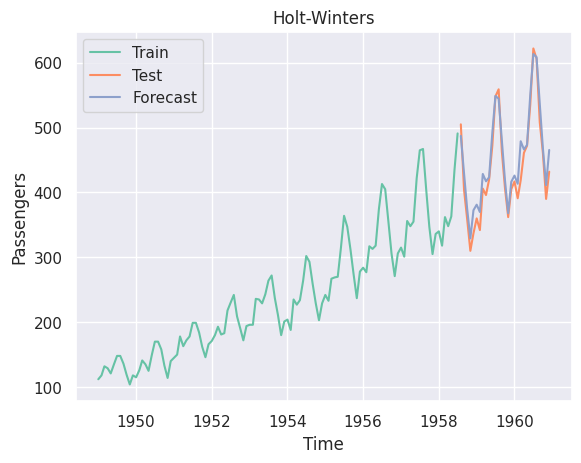

In [ ]:
# Plot the train, test, and forecast data
plt.plot(train['Passengers (k)'], label='Train')
plt.plot(test['Passengers (k)'], label='Test')
plt.plot(predictions_hw, label="Forecast")

# Add title and legend to the plot
plt.title("Holt-Winters")
plt.xlabel("Time")
plt.ylabel("Passengers")
plt.legend()
plt.show()

In [ ]:
mae_hw = mae(test["Passengers (k)"], predictions_hw)
mape_hw = mape(test["Passengers (k)"], predictions_hw)

print(f"The MAE is {mae_hw:.2f}")
print(f"The MAPE is {100 * mape_hw:.2f} %")

The MAE is 17.46
The MAPE is 4.26 %


**Conclusions**

The "Air Passengers" dataset includes both trend and seasonality, thus, the Holt Winter displays the best performance.

# **Citing this notebook**
If you use this notebook in your work, please cite it as follows:

Linh, H. (2025). Machine Learning for Business. Lecture examples and exercises. (Version 1.0.0). URL: https://github.com/MsLinhEIU/MIS-451---Machine-Learning-for-Business-Analytics/tree/main